### PageRank Implementation 1

The PR reduces to find the solution to $Ax=x$, namely an eigenvector $x$ assosiacted to the eigenvalue $1$. We end up with that equation because we state that the score of a page is determined by the score of the connected pages weighted by their relevance.
 We aim at finding a unique solution, however disconnected network and dangling nodes are pathological situations. In order to tackle them, we consider the following matrix $$M_m = (1-m)A + mS$$ which is a column stochastic and has a unique PR vector. The idea behind this is to create a minimal (artificial) connection with all the network while maintaing the original link matrix.

To compute the PR vector we follow the iterative strategy $$x_{k+1}=(1-m)GDx_k+ez^tx_k.$$
We are using the power method which is an algorithm to determine the eigenvector corresponding to the largest eigenvalue of a matrix $A$. The idea is quite simple: given a diagonalizable matrix, there exist a change of basis such that the matrix is diagonal. As a consequence, on that basis performing $$Ax=(\lambda_1x_1,\ldots,\lambda_nx_n)$$
where $\lambda_1,\ldots,\lambda_n$ are eigenvalues. Since it is diagonal,
$$A^mx=(\lambda_1^mx_1,\ldots,\lambda_n^mx_n)$$
but if $\lambda_1$ is the largest eigenvalue, when normalizing and letting $m$ increasing $(\lambda_2^mx_2,\ldots,\lambda_n^mx_n)$ are negligible and so we end up with an eigenvector. Geometrically we are stretching on the direction of highest relevance. In our scenario, thanks to a theorem, we know that for a column stochastic matrix $A$ if we consider $M=(1-\alpha)A+\alpha S$ where $S$ is a perturbation by a uniform network and $\alpha \in (0,1)$, then $1$ is the largest eigenvalue.



For the implementation we use the Gnutella30 square sparse matrix of dimension 36.682.

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from google.colab import drive
import os
import pandas as pd
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
from scipy.sparse import csr_matrix, coo_matrix
file_path = '/content/drive/My Drive/Data Science UB/Numerical Linear Algebra/p2p-Gnutella30.txt'
n=36682

row, col = np.genfromtxt(file_path, delimiter=None, unpack=True)
col = col.astype(np.int32)
values = np.ones(len(row))
G = csr_matrix((values, (row, col)), shape=(n,n))
G_array=G.toarray()
#We compute the out degrees
out_degree = G_array.sum(axis=0)
diag = np.where(out_degree != 0,1/out_degree, 0)
D= scipy.sparse.diags(diag, 0)
#Now we compute the matrix A=GD
A=G.dot(D)
e=np.ones(n) #we have to convert into column vector.
#Now we are ready to compute the vector z:
m=0.15 #the Google parameter
A_coo = A.tocoo() #because we need to convert it in order to extract the column.
column=np.unique(A_coo.col) #because if I have the column then there is a non zero element, then I take the unique values of this.
z = np.zeros(n)
z[column] = m / n
z = np.where(z == 0, 1 / n, z)


<ipython-input-2-3c7daae5b0f7>:12: RuntimeWarning: divide by zero encountered in divide
  diag = np.where(out_degree != 0,1/out_degree, 0)


In [ ]:
#We are now ready to compute the PR vector of M_m
tol=1e-4
x0=1/n*np.ones(n)
iter=0
while True:
    temp=z.dot(x0)
    x1 = (1 - m) * A.dot(x0) + e*temp
    if np.linalg.norm(x1 - x0, np.inf) <= tol:
        break
    x0 = x1
    iter+=1
print("The solution is:", x1)
print('Number of iterations:', iter)


The solution is: [1.34576685e-04 4.42540806e-06 6.59006990e-05 ... 4.42540806e-06
 4.42540806e-06 4.42540806e-06]
Number of iterations: 7


Let us check that the solution is correct: $x_1$ should be such that $M_mx_1=x_1$ where we recall that $mS=ez$ with our notation. We can compute the distance between $x_1$ and $M_mx_1$ and actually we obtain that the vector compute satisfies the equation: the error is approximately $1.55\cdot10^{-9}$

In [ ]:
test_vector=(1 - m) * A.dot(x0) + e*z.dot(x1)
print(np.linalg.norm(x1 - test_vector, np.inf))

1.5565317497369044e-09


In [ ]:
print(max(x1)) #This is the most important node according to the PR algorithm.
#The page associated to that value will be displayed as first

0.001383788655875284


###The role of the parameter $m$ ###

Let us see what happens if we change the value of $m$. The parameter $m$ is known also as damping factor. It affects how likely a random user is to follow a link versus teleporting to a random page. If we use small values for $m$ we are actually not considering the matrix $S$ which adds "randomness" to our case. On the other hand, if we use big values for $m$ actually we are cancelling the effect of $A$ which is representing our network and we are giving more space to randomness.
Below we tried different values of $m$ and what can be seen is that augmenting the value of $m$ decrease the number of iterations. The variance of the vector (we wanted to check how spread is the solution $x1$) is almost of the same order. The maximum value decrease with the increasing of the value $m$. This is not relevant since we are ordering the vector, but if we consider that value as "the importance of the page" then we can conclude that lower values of $m$ give a greater importance to the pages.

As a consequence, these observations align with the intuition behind the damping factor in PageRank. A bigger $m$ places more emphasis on the random teleportation behavior, while a smaller $m$ emphasizes link-following behavior, leading to slower convergence since we are investigating the structure of the network. From the other perspective, a larger $m$ emphasizes randomness and promotes quicker convergence, as link-following behavior becomes less significant. The parameter $m$ influences the trade-off between link structure and randomness in the PageRank algorithm.

In [ ]:
import pandas as pd

def solPR(m_values):
    results = []

    for m in m_values:
        A_coo = A.tocoo()
        column = np.unique(A_coo.col)
        z = np.zeros(n)
        z[column] = m / n
        z = np.where(z == 0, 1 / n, z)
        tol = 1e-4
        x0 = 1 / n * np.ones(n)
        iter_count = 0

        while True:
            temp = z.dot(x0)
            x1 = (1 - m) * A.dot(x0) + e * temp
            if np.linalg.norm(x1 - x0, np.inf) <= tol:
                break
            x0 = x1
            iter_count += 1

        max_element = np.max(x1)
        variance = np.var(x1)
        results.append({'m': m, 'iterations': iter_count, 'max_element': max_element, 'variance': variance})

    df_results = pd.DataFrame(results)
    return df_results

#We test these 5 values of m
m_values_to_test = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]
result_dataframe = solPR(m_values_to_test)

print(result_dataframe)


      m  iterations  max_element      variance
0  0.10          11     0.001684  5.013072e-09
1  0.20           7     0.001191  2.951423e-09
2  0.25           6     0.001016  2.329729e-09
3  0.30           5     0.000884  1.854707e-09
4  0.40           4     0.000651  1.193315e-09
5  0.50           2     0.000442  7.499147e-10


### PageRank Implementation 2

The idea of the second implementation is to work without storing matrices. More precisely, the idea is to compute the iterations $x_{k+1}=M_mx_{k}$ without considering the matrix $M_m$.

In [ ]:
G_coo=G.tocoo() #Because we have to access the set of indices L_j corresponding to pages having a link with page j.
from collections import defaultdict

#Now for these indexes we have to store the pages having a connection with that page. For example for page 0 (column)
#we have to store which pages are connected to that page, namely the elements of the form (x,0) and we have to do that for all col_index
col_index =np.arange(0,36682) #we iterate

#we initialize a dictionary
L= defaultdict(list)
n=[] #now in n we want to store the lenght of the set L_j, so n_j=|L_j|.

for col in col_index:
    linked_pages = G_coo.row[G_coo.col == col].tolist()
    L[col] = linked_pages
    n.append(len(L[col]))

#Now we are ready to use the function provided that computes the product M_m*x_k without storing the matrix.

dim=36682 #We have to change the name of the lenght of the matrix because now n stands for another variable.
m=0.15

def multiplication(x,L,n):
  xc=x
  x=np.zeros(dim) #we change this because we have to access the indexes.
  for j in range (0,dim):
    if(n[j]==0):
      x=x+xc[j]/dim
    else:
      for i in L[j]:
        x[i]=x[i]+xc[j]/n[j]
  x=(1-m)*x+m/dim
  return x


In [ ]:
#Here now we proceed with the Power Method.
tol=1e-4
x0=1/dim*np.ones(dim) #Initialization
iter=0
while True:
    x1=multiplication(x0,L,n)
    if np.linalg.norm(x1 - x0, np.inf) <= tol:
        break
    x0 = x1
    iter+=1
print("The solution is:", x1)
print('Number of iterations:', iter)

The solution is: [1.34576685e-04 4.42540806e-06 6.59006990e-05 ... 4.42540806e-06
 4.42540806e-06 4.42540806e-06]
Number of iterations: 7


As we can see from above the solution and the number of iterations (which is consistent since we are doing the same operations at the end) are the same as those we obtained in the first implementation, but in this case we have never stored the matrix $A$. The general idea, is to exploit the structure of the matrix $M_m$ that essentially is a repetition of the same quantities due to the nature of $S$. Another relevant thing is that the matrix $D$ since it is diagonal when you have a $0$ then the effect of $A$ is cancelled and you have to consider just $S$. This is consistent with the interpretation of the network: when $D$ has a $0$ elements, it means that $n_j$ is $0$ and so the page has no connection: hence for that page we use the randomness connection imposed by matrix $S$. On the other hand, when $n_j$ is non zero, we consider both the effect of both matrixes and we take into consideration the importance of the pages connected , that's why we compute $x_i=x_i+xc_j/n_j$ in the multiplication function. At the end of the function $x=(1-m)*x+m/dim$ allow us to weight the vector accordingly to the damping factor and the background connection of our network.

###The role of tolerance ###


Since before we played with the value $m$ we can try different values for the tolerance and check their impact on the number of iterations.

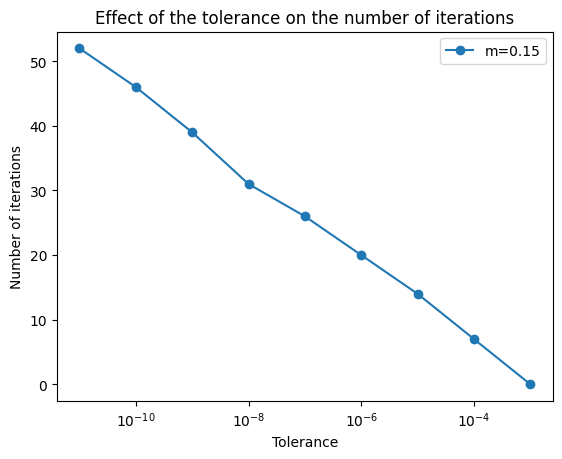

In [ ]:
#We define the function to call it
def pagerank_algorithm(L, x0, tol):
    iter = 0
    while True:
        x1 = multiplication(x0, L, n)
        if np.linalg.norm(x1 - x0, np.inf) <= tol:
            break
        x0 = x1
        iter += 1
    return iter

# Lista di valori di tolleranza
tolerances = np.logspace(-3, -11, num=9)
iterations_list =[]

for tol in tolerances:
    x0 = 1/dim * np.ones(dim)  # #Initialization
    iterations = pagerank_algorithm(L, x0, tol)
    iterations_list.append(iterations)

# Plot
plt.plot(tolerances, iterations_list, marker='o', label=f'm={m}') #to remind the value of m we are using
plt.xscale('log')  # We use a logaritmic scale
plt.xlabel('Tolerance')
plt.ylabel('Number of iterations')
plt.legend()
plt.title('Effect of the tolerance on the number of iterations')
plt.show()


The graph shows the effect of decreasing the tolerance in the number of iterations. It highlights what we expected, namely that the number of iterations required to obtain a more precise solution is higher. At $10^{-8}$ the graph steepens because the number of iterations to attains a more accurate solution increases.